# Objective

Determine the functional differences (if any exist to be found) in the proteome of the microbiome between RAG-Tcell Transfer (IBD Model) and RAG (Helthy Control) mice.  Ratio quantification using N15 isotopic labeling of the proteins of the microbiome should help to elucidate minor differences, while spectoral counting methods will be used to identify gross differences in proteomic content.

## Read and store sample data as classes

In [1]:
import sys
sys.path.append('..')
import os
from itertools import chain
import shelve
from tqdm import tqdm
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from adjustText import adjust_text

from scripts import utils
from scripts.analysis import build_loci
from scripts.analysis.DBInfo import DBInfo

BASE = '../data'

db_info = DBInfo("compil_mgm")
metadata = build_loci.read_metadata(os.path.join(BASE,"metadata.csv"))

`metadata.csv` was generated using the script `make_metadata.py` located in the `scripts` directory.  This file extracts metadata about each sample encoded into the directory names, and places them into a csv file that is used by build loci to perform the correct analysis pipelines on a given sample.

In [2]:
samples = shelve.open(os.path.join(BASE,"Samples.shelve"))
"""
for sample_name, sample_info in tqdm(list(metadata.iteritems())):
    sample = build_loci.Sample(sample_name, sample_info.path, db_info, sample_info)
    samples[sample.sample_name] = sample
"""

'\nfor sample_name, sample_info in tqdm(list(metadata.iteritems())):\n    sample = build_loci.Sample(sample_name, sample_info.path, db_info, sample_info)\n    samples[sample.sample_name] = sample\n'

In [3]:
protein_clusters = shelve.open(os.path.join(BASE,"Protein_clusters.shelve"))
"""
for name, sample in tqdm(samples.items()):
    protein_clusters[name] = sample.build_protein_clusters()
"""

'\nfor name, sample in tqdm(samples.items()):\n    protein_clusters[name] = sample.build_protein_clusters()\n'

Get the list of N15 quantified, unenriched samples.

In [4]:
unenr_keys = []
for key, sample in samples.items():
    if sample['quant'] and not sample['enriched']:
        unenr_keys.append(key)
unenr_keys = sorted(unenr_keys, key=lambda x: (x.split('_')[2], x.split('_')[-1], x.split('_')[-2]=='N'))

In [5]:
rt_un_keys = [key for key in unenr_keys if not '_N_' in key]
rag_un_keys = [key for key in unenr_keys if '_N_' in key]

## Plot venn diagrams showing run to run cluster composition for the samples

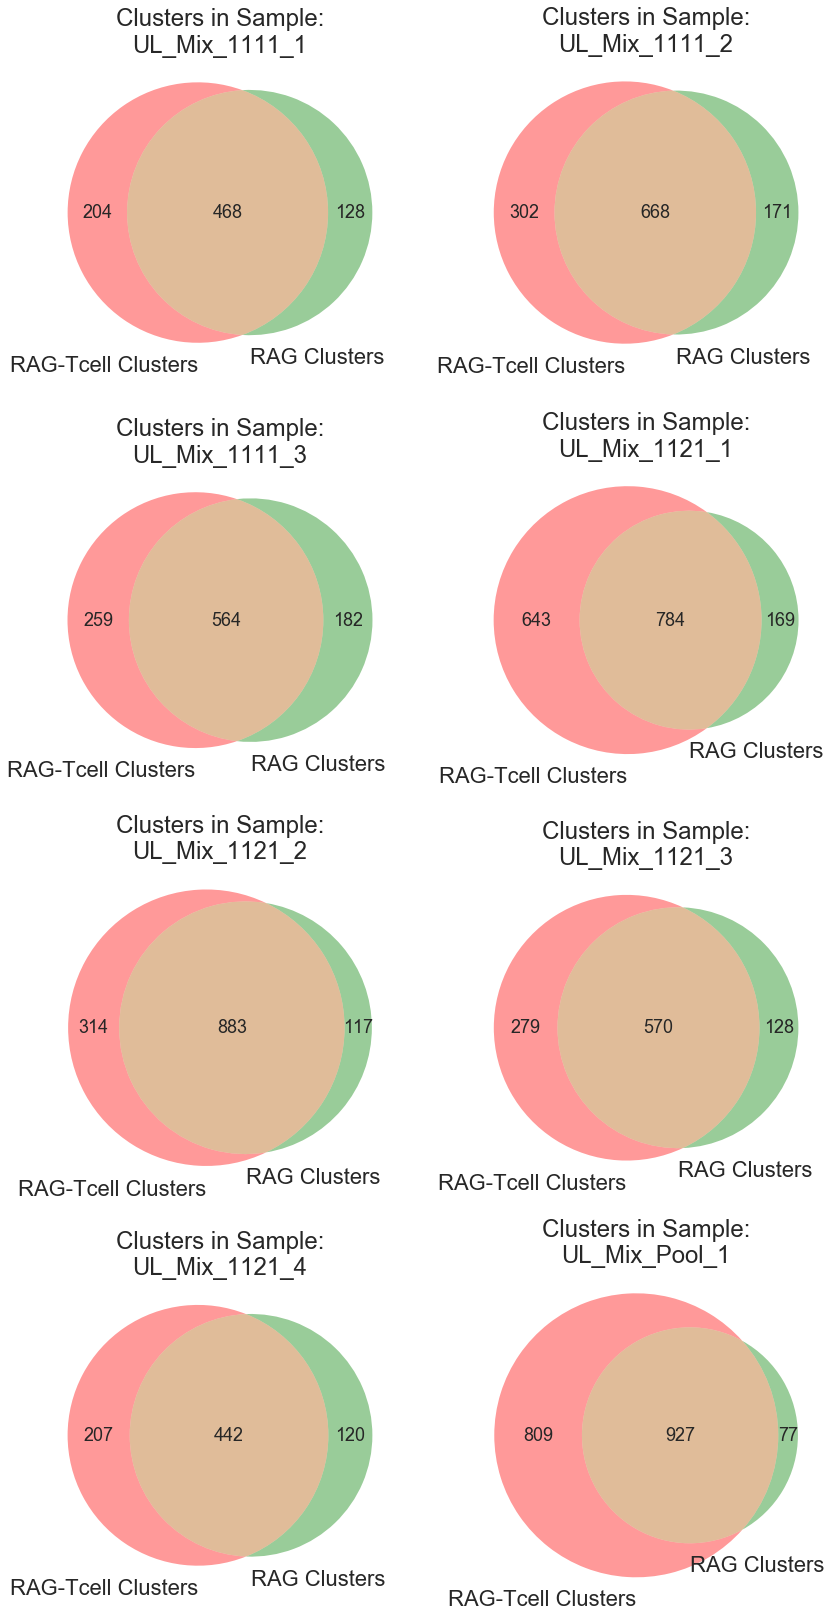

In [6]:
from matplotlib_venn import venn2

rows = len(unenr_keys)//4

fig, ax = plt.subplots(rows,2)
fig.set_tight_layout(False)
fig.set_size_inches(14,28)

for i, (l, h) in enumerate(zip(rt_un_keys, rag_un_keys)):
    light = set(p.cluster_id for p in protein_clusters[l])
    heavy = set(p.cluster_id for p in protein_clusters[h])
    
    v = venn2((light, heavy), ('RAG-Tcell Clusters', 'RAG Clusters'), ax = ax[i//2][i%2])
    
    for txt in v.set_labels:
        txt.set_fontsize(22)
    for text in v.subset_labels:
        text.set_fontsize(18)
    ax[i//2][i%2].set_title('Clusters in Sample:\n{}'.format(l), size = 24)

plt.savefig(os.path.join(BASE, 'unenr_clusters.png'), dpi = 100);

`UL_Mix_1121_1` (Row 2, Right side) and `UL_Mix_Pool_1` (Bottom Row, Right side) both look like they have diminished RAG Clusters, definitely looking different from the rest.  

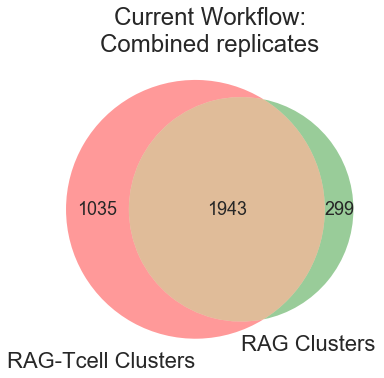

In [7]:
fig, ax = plt.subplots(1,1)
fig.set_tight_layout(False)


rt_clust = set()
rag_clust = set()
for i, (l, h) in enumerate(zip(rt_un_keys, rag_un_keys)):
    rt_clust.update(set(p.cluster_id for p in protein_clusters[l]))
    rag_clust.update(set(p.cluster_id for p in protein_clusters[h]))
v = venn2((rt_clust, rag_clust), ('RAG-Tcell Clusters', 'RAG Clusters'))
    
for txt in v.set_labels:
    txt.set_fontsize(22)
for text in v.subset_labels:
    text.set_fontsize(18)
plt.title('Current Workflow:\nCombined replicates', size = 24);

## Make Datatables from the data

In [8]:
"""
unenr_clusters = {k:v for k, v in protein_clusters.items() if k in unenr_keys}
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in unenr_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in unenr_keys}

unenr_grouped_loci = build_loci.group_across_samples(list(chain(*unenr_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(unenr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_un_keys) #Only quantify ratios across N14 identifications
"""

unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"))

load obo file ../scripts/go-basic.obo
46933 nodes imported
  0%|          | 0/3277 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
100%|██████████| 3277/3277 [01:04<00:00, 51.12it/s]


In [9]:
unenr_samples = {k:v for k, v in samples.items() if k in unenr_keys}
nf = build_loci.yates_normalization(unenr_samples)

316 common peptides for Normalizaion


In [10]:
for locus in unenr_grouped_loci:
    locus.normalize(nf)
build_loci.to_json(unenr_grouped_loci, unenr_keys, os.path.join(BASE, 'unenriched_Rag_Tcell_ratio.json'))

#Uncomment on first runthrough:
#utils.save(unenr_grouped_loci, os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"), force=True)

### Datatable Link
**[Unenriched Protein Clusters](http://wl-cmadmin:8000/ratiotable/unenriched_Rag_Tcell_ratio)**

## PCA Plot of the Unenriched Samples

explained variance ratios: [ 0.20009155  0.14410704]


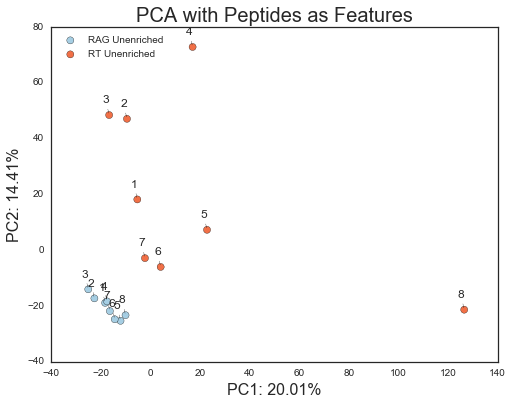

In [11]:
df = build_loci.to_df(unenr_grouped_loci, ratios=False, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys], title='PCA with Peptides as Features', group_name='category', loc=2, label_points=True)

explained variance ratios: [ 0.26436712  0.1160455 ]


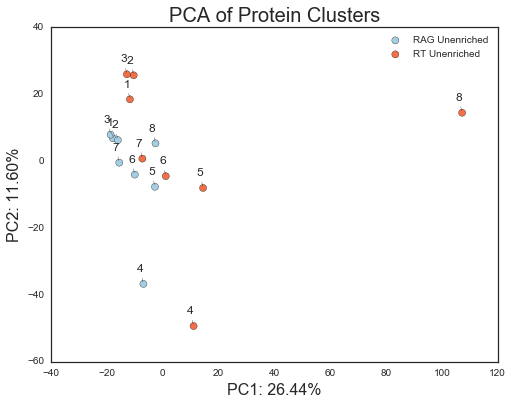

In [12]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys], group_name='category', loc=1, label_points=True)

Sample 8 looks like it could be an outlier, as well as potentially Sample 4.  We will remember this and look into it, but first lets prep the data for the Enriched Samples

# Enriched Samples

In [13]:
enr_keys = []
ctl_keys = []
for key, sample in samples.items():
    if sample['quant'] and sample['enriched'] and sample['probe'] == 'CMK':
        enr_keys.append(key)
    if sample['quant'] and sample['enriched'] and sample['probe'] == 'DMSO':
        ctl_keys.append(key)
enr_keys = sorted(enr_keys, key=lambda x: (x.split('_')[2], x.split('_')[-1], x.split('_')[-2]=='N'))
ctl_keys = sorted(ctl_keys, key=lambda x: (x.split('_')[2], x.split('_')[-1], x.split('_')[-2]=='N'))

In [14]:
rt_enr_keys = [key for key in enr_keys if not '_N_' in key]
rag_enr_keys = [key for key in enr_keys if '_N_' in key]

## Filter out clusters commonly found in DMSO Controls

If 10+ counts in a sample, most likely, this locus has a non-specific interaction to the beads, and isn't just noise

In [15]:
loci_to_filter = []
all_loci = []
for sample in ctl_keys:
    for locus in protein_clusters[sample]:
        if locus.quantification['counts'] >= 10:
            loci_to_filter.append(locus.cluster_id)
        all_loci.append(locus.cluster_id)
loci_to_filter = set(loci_to_filter)
all_loci = set(all_loci)

print('Total Loci in DMSO Samps: {}'.format(len(all_loci)))
print('Loci with enough counts to filter: {}\n\n'.format(len(loci_to_filter)))


print('Filtering per sample:\nSample\t\tBeforeFilt\tAfterFilt\tTotalFiltered')
filt_clusters = dict()
for sample in enr_keys:
    count = 0
    a = protein_clusters[sample]
    print('{}\t{}'.format(sample, len(a)), end='')
    for locus in protein_clusters[sample]:
        if locus.cluster_id in loci_to_filter:
            a.remove(locus)
            count += 1
    print('\t\t{}\t\t{}'.format(len(a), count))
    filt_clusters[sample] = a

Total Loci in DMSO Samps: 415
Loci with enough counts to filter: 248


Filtering per sample:
Sample		BeforeFilt	AfterFilt	TotalFiltered
CL_Mix_1120_1	1581		1483		98
CL_Mix_1120_N_1	667		636		31
CL_Mix_Pool_1	1550		1396		154
CL_Mix_Pool_N_1	868		829		39
CL_Mix_Pool_2	740		637		103
CL_Mix_Pool_N_2	530		500		30
CL_Mix_Pool_3	1147		1021		126
CL_Mix_Pool_N_3	640		604		36
CL_Mix_Pool_4	800		679		121
CL_Mix_Pool_N_4	357		326		31
CL_Mix_Pool_5	1568		1432		136
CL_Mix_Pool_N_5	581		545		36


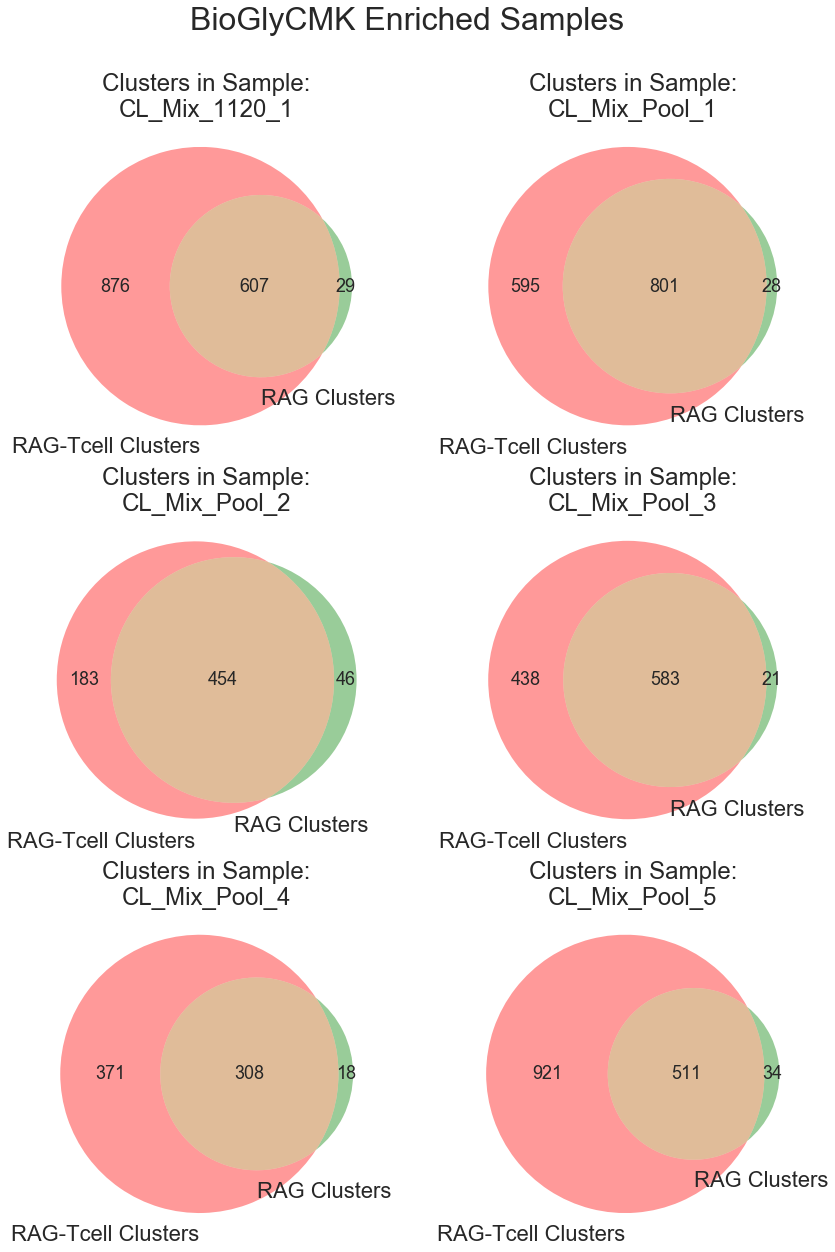

In [16]:
rows = len(enr_keys)//4

fig, ax = plt.subplots(rows,2)
fig.set_tight_layout(False)
fig.set_size_inches(14,20)
fig.suptitle('BioGlyCMK Enriched Samples', size=32)


for i, (l, h) in enumerate(zip(rt_enr_keys, rag_enr_keys)):
    light = set(p.cluster_id for p in filt_clusters[l])
    heavy = set(p.cluster_id for p in filt_clusters[h])
    
    v = venn2((light, heavy), ('RAG-Tcell Clusters', 'RAG Clusters'), ax = ax[i//2][i%2])
    
    for txt in v.set_labels:
        txt.set_fontsize(22)
    for text in v.subset_labels:
        text.set_fontsize(18)
    ax[i//2][i%2].set_title('Clusters in Sample:\n{}'.format(l), size = 24)

plt.savefig(os.path.join(BASE, 'enr_clusters.png'), dpi = 100);

In [41]:
"""
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in enr_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in enr_keys}

enr_grouped_loci = build_loci.group_across_samples(list(chain(*filt_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(enr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_enr_keys) #Only quantify ratios across N14 identifications
"""
#enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci.pkl.gz"))

  0%|          | 0/4795 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
100%|██████████| 4795/4795 [01:31<00:00, 52.62it/s]


In [18]:
enriched_samples = {k:v for k, v in samples.items() if k in enr_keys}
nf = build_loci.yates_normalization(enriched_samples)

for locus in enr_grouped_loci:
    locus.normalize(nf)
build_loci.to_json(enr_grouped_loci, enr_keys, '../data/bioGlyCMK_enriched_Rag_Tcell_ratio.json')

#utils.save(enr_grouped_loci, os.path.join(BASE,"enriched_grouped_loci.pkl.gz"), force=True)

292 common peptides for Normalizaion


### Datatable of loci and all Enriched samples
**[Link to Datatable](http://wl-cmadmin:8000/ratiotable/bioGlyCMK_enriched_Rag_Tcell_ratio)**

explained variance ratios: [ 0.22523893  0.19785355]


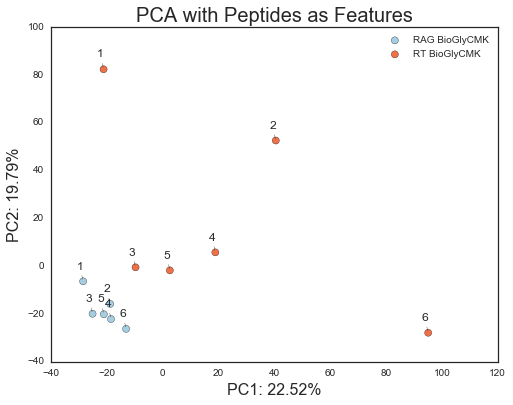

In [19]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[enr_keys], title='PCA with Peptides as Features', group_name='category', loc=1, label_points=True)

explained variance ratios: [ 0.30724498  0.25034961]


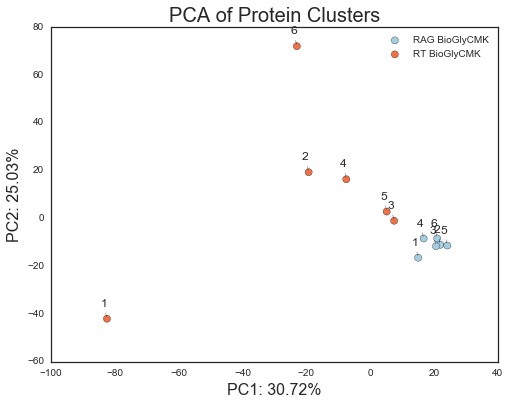

In [20]:
df = build_loci.to_df(enr_grouped_loci, ratios=False, peptides=True)
build_loci.plot_pca(df, metadata[enr_keys], group_name='category', loc=1, label_points=True)

# Unenriched and Enriched Samples

In [21]:
unenr_clusters = {k:v for k, v in protein_clusters.items() if k in unenr_keys}
both_clusters = filt_clusters
both_clusters.update(unenr_clusters)
both_keys = enr_keys + unenr_keys

In [22]:
"""
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in both_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in both_keys}
grouped_loci = build_loci.group_across_samples(list(chain(*both_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(grouped_loci):
    locus.annotate()
    locus.quantify(rt_un_keys+rt_enr_keys) #Only quantify ratios across N14 identifications
"""
grouped_loci = utils.load(os.path.join(BASE,"grouped_loci.pkl.gz"))

  0%|          | 0/4795 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
100%|██████████| 4795/4795 [01:32<00:00, 51.78it/s]


In [23]:
both_samples = {k:v for k, v in samples.items() if k in both_keys}
nf = build_loci.yates_normalization(both_samples)
for locus in grouped_loci:
    locus.normalize(nf)
    
#utils.save(grouped_loci, os.path.join(BASE,"grouped_loci.pkl.gz"), force=True)

205 common peptides for Normalizaion


explained variance ratios: [ 0.13865883  0.09855992]


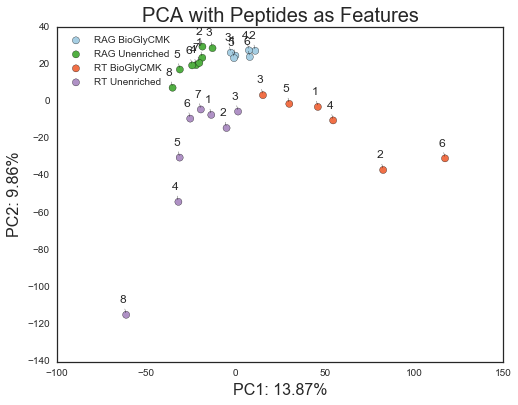

In [24]:
df = build_loci.to_df(grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys+enr_keys], title='PCA with Peptides as Features', group_name='category', loc=2, label_points=True)

explained variance ratios: [ 0.16101348  0.11323729]


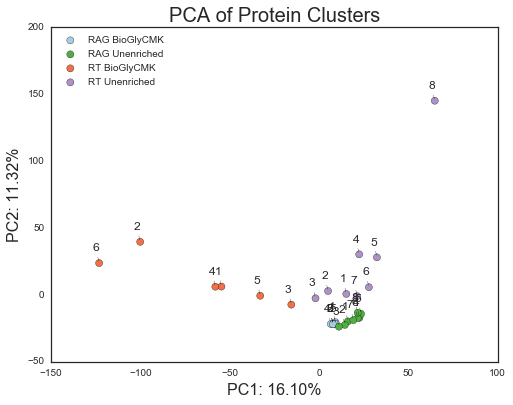

In [25]:
df = build_loci.to_df(grouped_loci, ratios=False, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys+enr_keys], group_name='category', loc=2, label_points=True)

# Volcano plot for significantly enriched loci

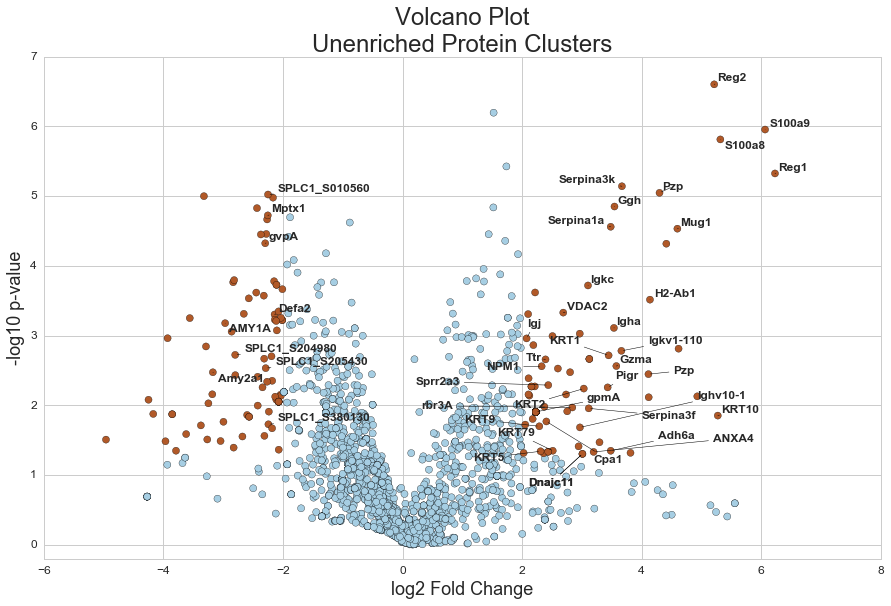

In [26]:
texts = build_loci.plot_volcano(unenr_grouped_loci, title='Volcano Plot\nUnenriched Protein Clusters', labels=True)

In [27]:
build_loci.sig_up_json(unenr_grouped_loci, rt_un_keys, os.path.join(BASE, 'all_unenriched_sig_up.json'), norm=False)
build_loci.sig_down_json(unenr_grouped_loci, rt_un_keys, os.path.join(BASE, 'all_unenriched_sig_down.json'), norm=False)

## The list of up and downregulated Protein Clusters can be found here:  
**[Significantly upregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/all_unenriched_sig_up)**  
**[Significantly downregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/all_unenriched_sig_down)**

### Enriched Samples

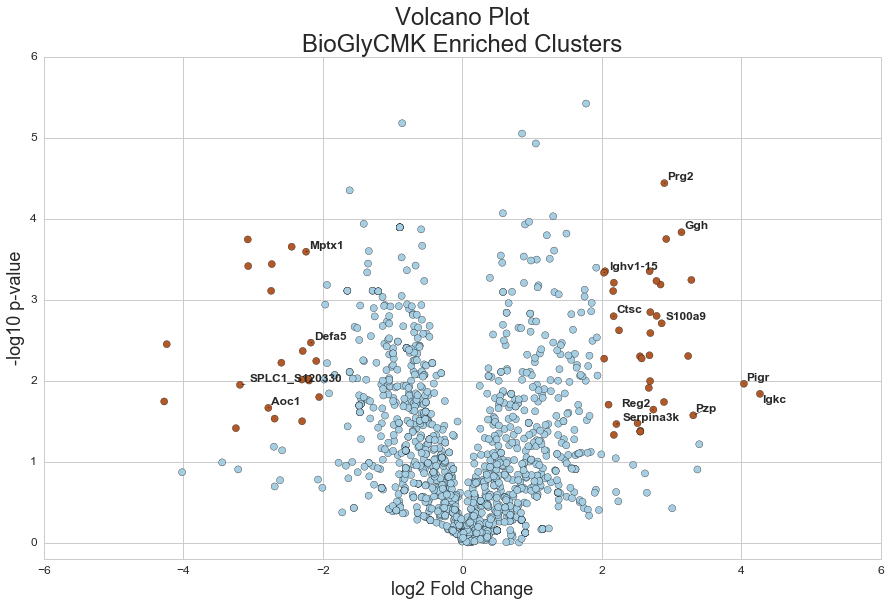

In [28]:
build_loci.plot_volcano(enr_grouped_loci, title='Volcano Plot\nBioGlyCMK Enriched Clusters', labels=True);

In [29]:
build_loci.sig_up_json(enr_grouped_loci, rt_enr_keys, os.path.join(BASE, 'all_enriched_sig_up.json'), norm=False)
build_loci.sig_down_json(enr_grouped_loci, rt_enr_keys, os.path.join(BASE, 'all_enriched_sig_down.json'), norm=False)

## View Significance tables here:  
**[Significantly upregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/all_enriched_sig_up)**  
**[Significantly downregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/all_enriched_sig_down)**

# GO Term Enrichment

Simple hypergeometric tests to see if a given GO term has a significantly greater number of occurances in one sample type over another time.  Ratios and weights are not taken into account in this metodology (execpt in that those with no ratio or counts are ignored).  Instead, the number of protein loci in a given sample type with a specific GO term is the primary metric for determining enrichment.


### Unenriched: RAG vs Tcell

In [30]:
from scripts.analysis import gsea
g = gsea.GSEA()

# Assign groups to each locus
groups = {'RAG': rag_un_keys, 'Tcell': rt_un_keys}

for locus in unenr_grouped_loci:
    locus.group = []
    samples_in_locus = {sample for sample, quant in locus.quantification.items() if (quant['ratio'] > 0 or quant['counts'] >= 5)}
    for group, members in groups.items():
        if set(members) & samples_in_locus:
            locus.group.append(group)
    
# Get go terms for each group {CID: [GO_Terms], ...}
Rag = {locus.cluster_id:locus.annotations['go'] for locus in unenr_grouped_loci if 'RAG' in locus.group and 'go' in locus.annotations}
Tcell = {locus.cluster_id:locus.annotations['go'] for locus in unenr_grouped_loci if 'Tcell' in locus.group and 'go' in locus.annotations}

rag_annot = defaultdict(list)
tcell_annot = defaultdict(list)

#rag_annot.update(g.generate_go_sets(Rag))
for cluster_id, annotations in Rag.items():
    for annotation in annotations:
        rag_annot[annotation].append(cluster_id)
#tcell_annot.update(g.generate_go_sets(Tcell))
for cluster_id, annotations in Tcell.items():
    for annotation in annotations:
        tcell_annot[annotation].append(cluster_id)

annotations = {locus.cluster_id:locus.annotations['go'] for locus in unenr_grouped_loci if 'go' in locus.annotations}
#all_annotations = set(chain(*[locus.annotations['go'] for locus in grouped_loci if 'go' in locus.annotations]))

#annotations = g.generate_go_sets(annotations)

all_annotations = set(list(rag_annot.keys()) + list(tcell_annot.keys()))



load obo file ../scripts/go-basic.obo
46933 nodes imported


In [31]:
# pop is group1 + group2
def enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose = True):
    import scipy.stats as stats

    pval = stats.hypergeom.sf(num_in_sub - 1, len_pop, num_in_pop, len_sub)
    if verbose:
        print('number with condition in population: ' + str(num_in_pop))
        print('length pop: ' + str(len_pop))
        print('number with condition in subset: ' + str(num_in_sub))
        print('length sub: ' + str(len_sub))
        print('p-value >= ' + str(num_in_sub) + ': ' + str(pval))
    return pval

### RAG vs TCell

In [32]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(rag_annot[annotation])|set(tcell_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(rag_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(Rag.keys())|set(Tcell.keys()))
    # number of proteins/clusters in subset
    len_sub = len(Rag)
    pv[annotation] = [enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False), num_in_sub, num_in_pop]

#[g.go_ontology[go].name for go in {k for k,v in pv.items() if v<0.0002}]
#pd.Series({g.go_ontology[k].name:v for k,v in pv.items() if v<0.0002}).to_frame().rename(columns={0:'p-value'}).sort_values(by=['p-value'])
res = (pd.DataFrame({g.go_ontology[k].name:v for k,v in pv.items() if v[0]<0.005})
         .T
         .rename(columns={0:'p-value', 1:'# in group', 2:'# in pop'})
         .sort_values(by=['p-value']))
res

,p-value,# in group,# in pop
ATP binding,0.000547,360.0,372.0
S-adenosylmethionine biosynthetic process,0.002407,81.0,81.0
methionine adenosyltransferase activity,0.002407,81.0,81.0
bacterial-type flagellum filament,0.002760,108.0,109.0
oxidoreductase activity,0.003730,370.0,385.0
DNA-directed RNA polymerase activity,0.004743,124.0,126.0
"transcription, DNA-templated",0.004743,124.0,126.0


### Tcell vs RAG

In [33]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(tcell_annot[annotation])|set(rag_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(tcell_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(Tcell.keys())|set(Rag.keys()))
    # number of proteins/clusters in subset
    len_sub = len(Tcell)
    pv[annotation] = [enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False), num_in_sub, num_in_pop]

res = (pd.DataFrame({g.go_ontology[k].name:v for k,v in pv.items() if v[0]<0.05})
         .T
         .rename(columns={0:'p-value', 1:'# in group', 2:'# in pop'})
         .sort_values(by=['p-value']))
res

,p-value,# in group,# in pop
oxidation-reduction process,0.045739,493.0,494.0


## Enriched

In [34]:
# Assign groups to each locus
groups = {'RAG': rag_enr_keys, 'Tcell': rt_enr_keys}

for locus in enr_grouped_loci:
    locus.group = []
    samples_in_locus = {sample for sample, quant in locus.quantification.items() if (quant['ratio'] > 0 or quant['counts'] >= 5)}
    for group, members in groups.items():
        if set(members) & samples_in_locus:
            locus.group.append(group)
    
# Get go terms for each group {CID: [GO_Terms], ...}
Rag = {locus.cluster_id:locus.annotations['go'] for locus in enr_grouped_loci if 'RAG' in locus.group and 'go' in locus.annotations}
Tcell = {locus.cluster_id:locus.annotations['go'] for locus in enr_grouped_loci if 'Tcell' in locus.group and 'go' in locus.annotations}

rag_annot = defaultdict(list)
tcell_annot = defaultdict(list)

#rag_annot.update(g.generate_go_sets(Rag))
for cluster_id, annotations in Rag.items():
    for annotation in annotations:
        rag_annot[annotation].append(cluster_id)
#tcell_annot.update(g.generate_go_sets(Tcell))
for cluster_id, annotations in Tcell.items():
    for annotation in annotations:
        tcell_annot[annotation].append(cluster_id)
        
annotations = {locus.cluster_id:locus.annotations['go'] for locus in enr_grouped_loci if 'go' in locus.annotations}
#all_annotations = set(chain(*[locus.annotations['go'] for locus in enr_grouped_loci if 'go' in locus.annotations]))
#annotations = g.generate_go_sets(annotations)

all_annotations = set(list(rag_annot.keys()) + list(tcell_annot.keys()))



 ### RAG vs TCell

In [35]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(rag_annot[annotation])|set(tcell_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(rag_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(Rag.keys())|set(Tcell.keys()))
    # number of proteins/clusters in subset
    len_sub = len(Rag)
    pv[annotation] = [enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False), num_in_sub, num_in_pop]

res = (pd.DataFrame({g.go_ontology[k].name:v for k,v in pv.items() if v[0]<0.0005}) #only 4 samps so higher threshold
         .T
         .rename(columns={0:'p-value', 1:'# in group', 2:'# in pop'})
         .sort_values(by=['p-value']))
res

,p-value,# in group,# in pop
pyruvate metabolic process,2.411003e-07,169.0,169.0
"pyruvate, phosphate dikinase activity",2.411003e-07,169.0,169.0
ATP binding,2.597816e-07,384.0,394.0
"transferase activity, transferring phosphorus-containing groups",4.664436e-07,162.0,162.0
phosphorylation,2.513697e-06,174.0,175.0
kinase activity,1.737685e-05,152.0,153.0


### T-cell vs RAG

In [36]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(tcell_annot[annotation])|set(rag_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(tcell_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(Tcell.keys())|set(Rag.keys()))
    # number of proteins/clusters in subset
    len_sub = len(Tcell)
    pv[annotation] = [enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False), num_in_sub, num_in_pop]

res = (pd.DataFrame({g.go_ontology[k].name:v for k,v in pv.items() if v[0]<0.5})
         .T
         .rename(columns={0:'p-value', 1:'# in group', 2:'# in pop'})
         .sort_values(by=['p-value']))
res

,p-value,# in group,# in pop
oxidoreductase activity,0.087547,473.0,473.0
metabolic process,0.221079,308.0,308.0
oxidation-reduction process,0.239204,553.0,554.0
cellular amino acid metabolic process,0.416505,185.0,185.0
phosphorylation,0.437679,175.0,175.0
pyruvate metabolic process,0.450838,169.0,169.0
"pyruvate, phosphate dikinase activity",0.450838,169.0,169.0
"transferase activity, transferring phosphorus-containing groups",0.466633,162.0,162.0
kinase activity,0.487663,153.0,153.0


## Enriched vs Unenriched

In [37]:
# Assign groups to each locus
groups = {'Enriched': enr_keys, 'Unenriched': unenr_keys}

for locus in grouped_loci:
    locus.group = []
    samples_in_locus = {sample for sample, quant in locus.quantification.items() if (quant['ratio'] > 0 or quant['counts'] >= 5)}
    for group, members in groups.items():
        if set(members) & samples_in_locus:
            locus.group.append(group)
    
# Get go terms for each group {CID: [GO_Terms], ...}
enr = {locus.cluster_id:locus.annotations['go'] for locus in grouped_loci if 'Enriched' in locus.group and 'go' in locus.annotations}
unenr = {locus.cluster_id:locus.annotations['go'] for locus in grouped_loci if 'Unenriched' in locus.group and 'go' in locus.annotations}

enr_annot = defaultdict(list)
unenr_annot = defaultdict(list)

enr_annot.update(g.generate_go_sets(enr))
#for cluster_id, annotations in enr.items():
#    for annotation in annotations:
#        enr_annot[annotation].append(cluster_id)

unenr_annot.update(g.generate_go_sets(unenr))
#for cluster_id, annotations in unenr.items():
#    for annotation in annotations:
#        unenr_annot[annotation].append(cluster_id)

annotations = {locus.cluster_id:locus.annotations['go'] for locus in grouped_loci if 'go' in locus.annotations}
#all_annotations = set(chain(*[locus.annotations['go'] for locus in grouped_loci if 'go' in locus.annotations]))
annotations = g.generate_go_sets(annotations)

all_annotations = set(list(enr_annot.keys()) + list(unenr_annot.keys()))



### Enriched vs Unenriched - Terms with more presence in Enriched Samples

In [38]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(enr_annot[annotation])|set(unenr_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(enr_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(enr.keys())|set(unenr.keys()))
    # number of proteins/clusters in subset
    len_sub = len(enr)
    pv[annotation] = [enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False), num_in_sub, num_in_pop]

res = (pd.DataFrame({g.go_ontology[k].name:v for k,v in pv.items() if v[0]<0.0002})
         .T
         .rename(columns={0:'p-value', 1:'# in group', 2:'# in pop'})
         .sort_values(by=['p-value']))
res

,p-value,# in group,# in pop
cellular process,4.995043e-291,1043.0,1043.0
cellular metabolic process,1.354062e-278,1008.0,1008.0
single-organism carbohydrate catabolic process,2.014330e-29,127.0,127.0
small molecule metabolic process,9.110602e-25,830.0,1150.0
hydro-lyase activity,6.395411e-21,90.0,90.0
carboxylic acid metabolic process,5.777579e-20,602.0,818.0
oxoacid metabolic process,7.322233e-20,603.0,820.0
organic acid metabolic process,1.132157e-19,620.0,847.0
oxidoreductase activity,4.358301e-19,626.0,859.0
oxidation-reduction process,3.400839e-18,640.0,885.0


### Unenriched vs Enriched - Terms with more presence in Unenriched samples

In [39]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(unenr_annot[annotation])|set(enr_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(unenr_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(unenr.keys())|set(enr.keys()))
    # number of proteins/clusters in subset
    len_sub = len(unenr)
    pv[annotation] = [enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False), num_in_sub, num_in_pop]

res = (pd.DataFrame({g.go_ontology[k].name:v for k,v in pv.items() if v[0]<0.0002})
         .T
         .rename(columns={0:'p-value', 1:'# in group', 2:'# in pop'})
         .sort_values(by=['p-value']))
res

,p-value,# in group,# in pop
single-organism metabolic process,6.884503e-215,1093.0,1093.0
nucleoside metabolic process,1.101673e-40,244.0,244.0
purine ribonucleoside metabolic process,2.420655e-40,242.0,242.0
purine ribonucleoside triphosphate metabolic process,3.587391e-40,241.0,241.0
ATP metabolic process,5.315717e-40,240.0,240.0
organelle part,3.156232e-29,226.0,232.0
organelle,2.449873e-27,287.0,306.0
non-membrane-bounded organelle,9.106191e-27,273.0,290.0
intracellular non-membrane-bounded organelle,1.054235e-26,161.0,161.0
structural molecule activity,1.489080e-24,277.0,298.0


All of the enrichment numbers aren't very trustworth.  They should probably be re-run via some other algorithm.